In [1]:
import pandas as pd
import re
import timeit as ti
import datetime as dt
import numpy as np
np.random.seed(4999)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.feature_selection import SelectFromModel

In [3]:
ds = pd.read_csv('datasets/train.csv')
price_cols = ['sellingprice','pr','pe']
make_cols = ['make','model','trim']
wear_cols = ['prod_year','condition','odometer']

In [4]:
%%time
ds[['make','model','trim']] = ds[['make','model','trim']].fillna('UNKNOWN')
ds[['color','interior']] = ds[['color','interior']].fillna('—')

CPU times: total: 625 ms
Wall time: 624 ms


In [5]:
%%time 
cols_to_upper= ['make','model','trim','body']
cols_dt = ['year','month','day','hour','minute','second','weekday','yearday','dl']
cols_abbr = ['trim','seller']
def transform_row(r,cols_to_upper,cols_dt,cols_abbr):
    def abbr(s,prefix_size=5 ):
        s = s.strip().upper()
        if len(s) <= prefix_size:
            return(s)
        s = s[:prefix_size].replace(' ','-')+s[prefix_size:]
        i = s.find(' ')
        if i > 0:
            s = s[:i]        
        return(s)
 
    t =  dt.datetime.strptime(r['saledate'].split('GMT')[0]  ,"%a %b %d %Y %H:%M:%S ").timetuple()
    dc = dict(zip(cols_dt ,t))
    for col in cols_abbr:
        dc['abbr_'+col] = abbr(r[col])

    for col in cols_to_upper:
        dc[col] = str(r[col]).upper()
    return dc
        
    
ds = ds.rename(columns={'year':'prod_year'})
#ds[cols_to_upper+['abbr_trim','abbr_seller']+cols_dt
transformed = ds.apply(transform_row, axis=1,result_type='expand',
                                     cols_to_upper=cols_to_upper,cols_dt=cols_dt,cols_abbr=cols_abbr)
ds[transformed.columns] = transformed   
#ds = ds.drop('saledate',axis=1)

CPU times: total: 52.3 s
Wall time: 54.9 s


In [6]:
%%time
cond_mean = ds.groupby('prod_year').condition.mean()
ds.loc[ds.condition.isna(),'condition'] = ds[ds.condition.isna()].prod_year.apply(lambda s: cond_mean[s])
run_mean = ds.groupby('prod_year').odometer.mean()
ds.loc[ds.odometer.isna(),'odometer'] = ds[ds.odometer.isna()].prod_year.apply(lambda s: run_mean[s])


CPU times: total: 297 ms
Wall time: 328 ms


In [7]:
%%time
tms = ds.groupby('model').transmission.value_counts().unstack(fill_value=0) 
tms['expected']= tms.apply( lambda r:  ['automatic','manual'][int(r.automatic < r.manual)], axis=1 )
idx = ds.transmission.isna()
def put_tms(t):
    try:
        return(tms.expected[t])
    except:
        return( 'automatic')
ds.loc[idx,'transmission'] = ds[idx].model.apply(put_tms)



CPU times: total: 984 ms
Wall time: 1.02 s


In [8]:
ds.head()

,prod_year,make,model,trim,body,transmission,vin,state,condition,odometer,...,month,day,hour,minute,second,weekday,yearday,dl,abbr_trim,abbr_seller
0,2011,FORD,EDGE,SEL,SUV,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,6,2,2,30,0,1,153,-1,SEL,SANTANDER
1,2014,FORD,FUSION,SE,SEDAN,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,2,25,2,0,0,2,56,-1,SE,ARS/AVIS
2,2012,NISSAN,SENTRA,2.0 SL,SEDAN,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,6,10,2,30,0,2,161,-1,2.0-SL,NISSAN-INFINITI
3,2003,HUMMER,H2,BASE,SUV,automatic,5grgn23u93h101360,tx,2.8,131301.0,...,6,17,3,0,0,2,168,-1,BASE,WICHITA
4,2007,FORD,FUSION,SEL,SEDAN,automatic,3fahp08z17r268380,md,2.0,127709.0,...,2,3,4,0,0,1,34,-1,SEL,PURPLE


In [9]:
%%time
ds.info()

# for s in ['a ','  x','d dfd','123 d','1234 e','12345 fg','12 45 g','123456']: 
#     print(s, transform_seller(s))
#ds['abbr_seller'] = ds.seller.apply(transform_seller,prefix_size=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   prod_year     440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  440236 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     440236 non-null  float64
 9   odometer      440236 non-null  float64
 10  color         440236 non-null  object 
 11  interior      440236 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
 15  year          440236 non-null  int64  
 16  month         440236 non-null  int64  
 17  day           440236 non-null  int64  
 18  hour

In [12]:
abbr_count = ds['abbr_seller'].value_counts()

def abbr_power(s):
    for i in range(6):
        if 2**i > abbr_count[s]:
            return('ABBR_T_'+str(i) )
    return(s)
# print( abbr_power('STUDIO'),abbr_power('PUMPKIN'),abbr_power('DOWNEY'),abbr_power('COULTER'),
#        abbr_power('ROMEO'),abbr_power('PURPLE') ) 
ds['abbr_power']= ds['abbr_seller'].apply(abbr_power)


g_abbr = ds.groupby('abbr_power').condition
q_abbr = pd.DataFrame( { 'q25': g_abbr.quantile(.25),'q75':g_abbr.quantile(.75)} )
#q_abbr.loc['159191']
ds[['q25','q75']] = ds.abbr_power.apply(lambda s: q_abbr.loc[s] )

abbr_cols = ['abbr_seller','abbr_power','q25','q75'] 
ds[make_cols+abbr_cols ]

CPU times: total: 37.1 s
Wall time: 38.9 s


In [14]:
trim_counts = ds.trim.value_counts() 
trim_counts[trim_counts > 128]

BASE             43876
SE               34498
LX               16511
LIMITED          14516
LT               13431
                 ...  
RUBICON            131
PASSION COUPE      130
325XI              130
330CI              130
SPORT PZEV         129
Name: trim, Length: 296, dtype: int64

In [15]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   prod_year     440236 non-null  int64  
 1   make          440236 non-null  object 
 2   model         440236 non-null  object 
 3   trim          440236 non-null  object 
 4   body          440236 non-null  object 
 5   transmission  440236 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     440236 non-null  float64
 9   odometer      440236 non-null  float64
 10  color         440236 non-null  object 
 11  interior      440236 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
 15  year          440236 non-null  int64  
 16  month         440236 non-null  int64  
 17  day           440236 non-null  int64  
 18  hour

In [16]:
for c in ds.columns:
    print(f"{c} : ----- { ds[c].value_counts().size } ============> NaNs: {sum(ds[c].isna()) }----")
    print(dict( ds[c].value_counts().head(10)) )
    print(dict( ds[c].value_counts().tail()) )
    print()

prod_year : ----- 34 ============> NaNs: 0----
{2012: 80625, 2013: 77566, 2014: 64225, 2011: 38115, 2008: 24646, 2007: 24152, 2006: 21118, 2010: 20647, 2005: 16794, 2009: 16064}
{1986: 8, 1987: 5, 1984: 4, 1983: 1, 1982: 1}

make : ----- 63 ============> NaNs: 0----
{'FORD': 74067, 'CHEVROLET': 47818, 'NISSAN': 42866, 'TOYOTA': 31711, 'DODGE': 24294, 'HONDA': 21600, 'HYUNDAI': 17187, 'BMW': 16254, 'KIA': 14325, 'CHRYSLER': 13796}
{'DAEWOO': 1, 'DODGE TK': 1, 'MAZDA TK': 1, 'DOT': 1, 'AIRSTREAM': 1}

model : ----- 840 ============> NaNs: 0----
{'ALTIMA': 15454, 'F-150': 11408, 'FUSION': 10244, 'CAMRY': 10000, 'ESCAPE': 9447, 'FOCUS': 8222, 'UNKNOWN': 8123, 'ACCORD': 7226, '3 SERIES': 6406, 'IMPALA': 6305}
{'420-CLASS': 1, 'C230': 1, 'RRS': 1, 'ACTIVEHYBRID 5': 1, 'G500': 1}

trim : ----- 1851 ============> NaNs: 0----
{'BASE': 43876, 'SE': 34498, 'LX': 16511, 'LIMITED': 14516, 'LT': 13431, 'XLT': 13173, 'LS': 10723, 'LE': 10231, 'GLS': 9707, 'S': 9649}
{'EXECUTIVE PZEV': 1, '4C BASE': 1

In [17]:
ds.head()

,prod_year,make,model,trim,body,transmission,vin,state,condition,odometer,...,minute,second,weekday,yearday,dl,abbr_trim,abbr_seller,abbr_power,q25,q75
0,2011,FORD,EDGE,SEL,SUV,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,30,0,1,153,-1,SEL,SANTANDER,SANTANDER,2.1,3.7
1,2014,FORD,FUSION,SE,SEDAN,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,0,0,2,56,-1,SE,ARS/AVIS,ARS/AVIS,3.7,4.3
2,2012,NISSAN,SENTRA,2.0 SL,SEDAN,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,30,0,2,161,-1,2.0-SL,NISSAN-INFINITI,NISSAN-INFINITI,3.4,4.3
3,2003,HUMMER,H2,BASE,SUV,automatic,5grgn23u93h101360,tx,2.8,131301.0,...,0,0,2,168,-1,BASE,WICHITA,WICHITA,2.9,4.1
4,2007,FORD,FUSION,SEL,SEDAN,automatic,3fahp08z17r268380,md,2.0,127709.0,...,0,0,1,34,-1,SEL,PURPLE,PURPLE,2.0,2.0


In [18]:
ds_vin = ds.vin
ds_ta = ds.sellingprice
trash_cols = ['saledate','trim','abbr_seller','seller','second','yearday','dl']
ds_fe = ds.drop(['vin','sellingprice']+trash_cols,axis=1)

In [19]:
enc= OrdinalEncoder()
ds_fe = pd.DataFrame( enc.fit_transform(ds_fe),columns = enc.get_feature_names_out() )

In [20]:
fe_tr,fe_va,ta_tr,ta_va = train_test_split(ds_fe,ds_ta,test_size = .25)
print( fe_tr.shape,fe_va.shape,ta_tr.shape,ta_va.shape)
fe_tr.head()

(330177, 20) (110059, 20) (330177,) (110059,)


,prod_year,make,model,body,transmission,state,condition,odometer,color,interior,year,month,day,hour,minute,weekday,abbr_trim,abbr_power,q25,q75
23324,25.0,8.0,729.0,40.0,0.0,6.0,41.0,99306.0,1.0,1.0,0.0,7.0,17.0,10.0,0.0,3.0,840.0,980.0,11.0,65.0
138483,32.0,44.0,320.0,7.0,0.0,32.0,65.0,8496.0,1.0,6.0,1.0,5.0,2.0,3.0,22.0,2.0,1156.0,646.0,122.0,117.0
65633,32.0,44.0,619.0,40.0,0.0,17.0,38.0,6701.0,14.0,16.0,1.0,5.0,7.0,2.0,22.0,0.0,972.0,793.0,18.0,78.0
377581,31.0,17.0,272.0,40.0,0.0,3.0,66.0,53405.0,7.0,0.0,1.0,4.0,25.0,5.0,0.0,1.0,1051.0,588.0,81.0,106.0
110954,31.0,33.0,202.0,24.0,0.0,28.0,57.0,14924.0,1.0,1.0,1.0,4.0,27.0,2.0,0.0,3.0,417.0,593.0,81.0,106.0


In [21]:
# %%time
# sel = SelectFromModel(
#      RandomForestRegressor(n_estimators = 20,max_depth = 8, criterion='squared_error',max_features=24)
# )
# sel.fit(fe_tr,ta_tr )
# pd.Series( sel.get_support(), index = fe_tr.columns )

In [22]:
# %%time
# for n_est in (13,21,34,55,89,144,233):
#     start = ti.default_timer()  
#     md = RandomForestRegressor(max_depth=32, n_estimators=n_est)
#     md.fit(fe_tr,ta_tr)
#     pr = pd.Series( md.predict(fe_va))
#     print(f"{n_est} : {mape(ta_va,pr)} | {ti.default_timer()-start}")

In [37]:
%%time
for n_est in [200]:
    for mss in [2]:
        for msl in [2]:
            for mf in [24]:
                for cri in ['poisson']:  
#            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=1.0
                    start = ti.default_timer()  
                    md = RandomForestRegressor(criterion=cri,max_depth=100, n_estimators=n_est,
       #                  random_state = 5555,                      
                         min_samples_split=mss, min_samples_leaf=msl, max_features=mf,
                         warm_start=True)
                    md.fit(fe_tr,ta_tr)
                    prt = pd.Series( md.predict(fe_va),index=fe_va.index )
                    print(f"est:{n_est} mss:{mss} msl:{msl} mf:{mf} cri:{cri}=> {mape(ta_va,prt)} | {ti.default_timer()-start}")

est:200 mss:2 msl:2 mf:24 cri:poisson=> 0.191677334974761 | 1001.776028399996
CPU times: total: 16min 2s
Wall time: 16min 41s


In [38]:
pr = prt

In [39]:
mape(ta_va,pr)

0.191677334974761

In [ ]:
RandomForestRegressor().get_params()

In [ ]:
# %%time
# md = DecisionTreeRegressor(max_depth=333)
# md.fit(fe_tr,ta_tr)
# prt = pd.Series( md.predict(fe_va),index=fe_va.index )
# mape(ta_va,prt)               

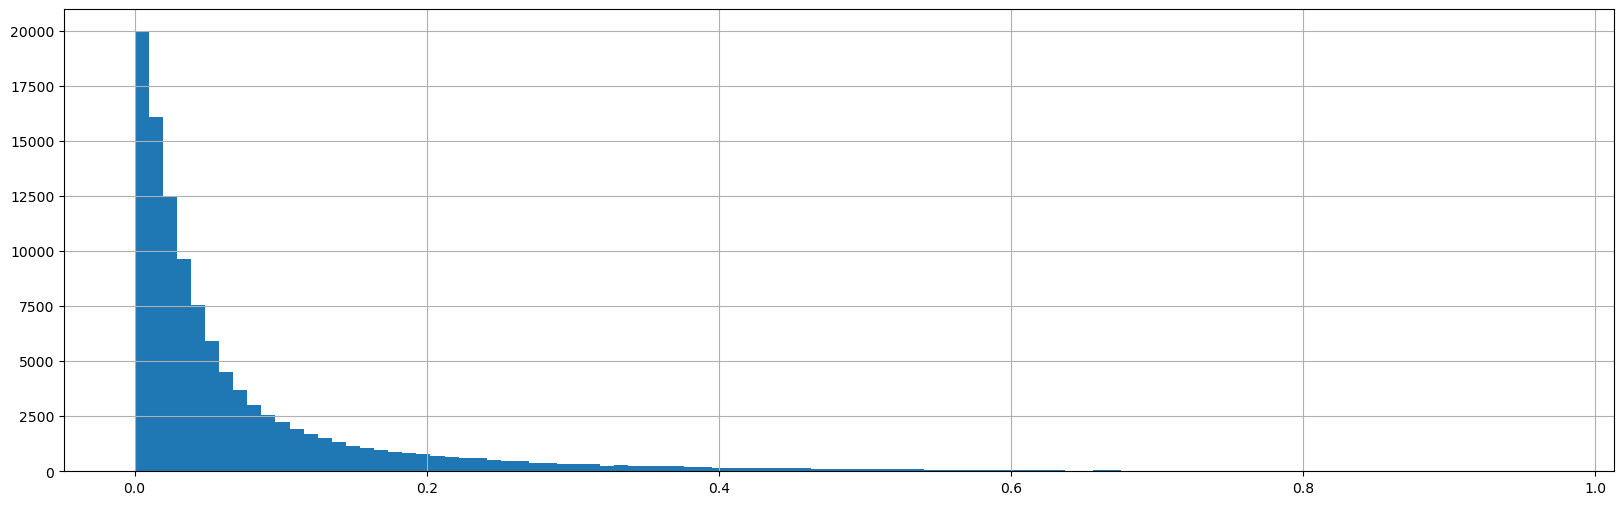

In [40]:
pe = abs(pr-ta_va)/(pr+ta_va)
pe.hist(figsize=(20,6),bins=100);

In [ ]:
ds['pr'] = pr
ds['pe'] = pe

In [ ]:
print( ds.sellingprice[ds.pe < 10_000_000 ].shape,pr.shape,ta_va.shape,(pr-ta_va).shape )
pr.head().index,ta_va.head().index,fe_va.head().index,(pr - ta_va).head().index

In [ ]:
# big_diffs = ds.loc[ abs(pr-ta_va).sort_values(ascending = False).head(60).index ]
# rel_diffs = ds.loc[pe.sort_values(ascending = False).head(60).index]
# diffs_33 = ds[pe >.33]
# diffs_33m = ds[pe <.33]
# diffs_50 = ds[pe >.5]
# diffs_50m = ds[pe <.5]
# diffs_66 = ds[pe >.66]
# diffs_66m = ds[pe < .66]
# mape

In [48]:
for th in [1000,2000,3500,5000]:
    print(f" {th}:\t { mape(pr[pr>th],ta_va[pr>th])} \t {pr[pr<th].shape} ")

 1000:	 0.13738394532504306 	 (1459,) 
 2000:	 0.12742516895944486 	 (5444,) 
 3500:	 0.11382301256480432 	 (12057,) 
 5000:	 0.10152179835842383 	 (18806,) 


In [ ]:
print(mape(ta_va[ds.pe<.25],pr[ds.pe<.25]),mape(ta_va[ds.pe<.5],pr[ds.pe<.5]),mape(ta_va[ds.pe<.75],pr[ds.pe<.75]))
#diffs_50_plus = 

In [ ]:
print( ds.sellingprice.mean(),pr.mean(),rel_diffs.sellingprice.mean(),rel_diffs.pr.mean() )
rel_diffs[price_cols+make_cols+wear_cols+['seller']+['abbr_power']+['q25']+['state']]

In [ ]:
pd.DataFrame( {
'd50': diffs_50.q25.value_counts().head(30),
'd66': diffs_66.q25.value_counts().head(30),
'ds': ds.q75.value_counts().head(30)
}    ).sort_values(by = 'd50',ascending=False)    

In [ ]:
raise

In [ ]:
#print( rel_diffs.seller.value_counts() )
#ds.seller.value_counts()

In [ ]:
cnd = ds.pivot_table(
    index='seller',values=['sellingprice','condition'],aggfunc=['mean','count']
)
cnd[ cnd[('count','condition')]>10000].sort_values(by=('mean','condition') )

In [ ]:
cheapsellers = list( ds[ds.sellingprice<1000].seller.value_counts().head(60).index )
print(ds[ds.seller.isin( cheapsellers )].groupby(ds.seller).sellingprice.quantile(.25) )
ds.groupby(ds.seller).condition.quantile(.25).head(60)

In [ ]:
ta_va[ta_va<2000].hist(bins=10,figsize = (20,8),alpha=.5);
pr[pr<2000].hist(bins=10,figsize = (20,8),alpha=.5);

In [ ]:
ds[ds.seller=='credit acceptance corp/vrs/southfield'].sellingprice.hist(bins=50,figsize = (20,8),alpha=0.5);
ds[ds.seller.str[:12]=='purple heart'].sellingprice.hist(bins=50,figsize = (20,8),alpha=0.5);

In [ ]:
ds[ds['abbr_power']=='PURPLE'].pr.quantile([.1,.25,.5,.75])

In [ ]:
ds[ds['abbr_power']=='QUALITY'].pr.quantile([.1,.25,.5,.75,.9])